In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import time
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## **MAIN CODE to get the rating and number of votes for each album**

In [106]:
df_ratings_scrapped = pd.read_csv('Datasets/df_ratings.csv')
start_id = df_ratings_scrapped['album_id'].iloc[-1]
start_id

225799

In [ ]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import ftfy   # to fix names with unusual characters

df_ratings_scrapped = pd.read_csv('Datasets/df_ratings.csv', keep_default_na=False)

album_id_list = []
artists_list = []
albums_list = []
avg_rating_list = []
number_of_votes_list = []

count = 0
scrapped = 0

start_id = df_ratings_scrapped['album_id'].iloc[-1]

for album_id in range(start_id+1,start_id+4000):
    count+=1

    if album_id in df_ratings_scrapped['album_id'].values:
        print(f'{scrapped}/{count} - id {album_id}: album already scrapped')
        continue  # Skip this album, I already have it

    url = f'https://www.sputnikmusic.com/soundoff.php?albumid={album_id}'
    response = requests.get(f"{url}")
    soup = BeautifulSoup(response.content, "html.parser")
    
    # Extract artist and album name
    info = soup.select('table tr')
    try:
        artist_name = info[2].text.split('dig it')[0].split('new music')[1].split('\xa0\xa0\xa0')[0].split('\n\n\n\n\n\n\n\n\n\n')[1]
        album = info[2].text.split('dig it')[0].split('new music')[1].split('\xa0\xa0\xa0')[1]
        album_name = ftfy.fix_text(album)     # fix the name 
    except IndexError:
        print(f"{scrapped}/{count} - id {album_id}: error")
        continue  # Skip this album if the info isn't formatted as expected
    if artist_name == '':
        print(f"{scrapped}/{count} - id {album_id}: No artist found")
        continue  # Skip this album if the info isn't formatted as expected

    print(f'{scrapped}/{count} - id {album_id}: {artist_name} - {album_name}')

    # Get ratings
    rating = soup.select('font.reviewheading b')
    ratings_list = []

    for r in rating:
        if len(r.text) == 3:  # Only consider ratings with 3 characters (like "4.5")
            ratings_list.append(r.text)

    # Convert to float
    rating_floats = [float(num) for num in ratings_list]
    
    if rating_floats:
        number_of_votes = len(rating_floats) # calculate the number of votes
        number_of_votes_list.append(number_of_votes) # save it in a list

        album_id_list.append(album_id)
        artists_list.append(artist_name)
        albums_list.append(album_name)

        avg_rating = round(np.mean(rating_floats),2) # calculate the avg rating
        avg_rating_list.append(avg_rating) # save it in a list

        scrapped+=1
    else:
        print(f"{scrapped}/{count} - id {album_id}: No valid ratings found.")

0/1 - id 224801: Head Washer - Guinea Pig
1/2 - id 224802: Carambolage - Eilzustellung-Exprés
1/2 - id 224802: No valid ratings found.
1/3 - id 224803: Under Two Palms - Under Two Palms
2/4 - id 224804: Drexciya - The Journey Home
3/5 - id 224805: Claudine Longet - Claudine
4/6 - id 224806: Originalton - Mein Leben ist ein Werbespot
5/7 - id 224807: Mad Tea Party - Hide and Seek
6/8 - id 224808: Among Gods - Ghost Empire
7/9 - id 224809: Sims - Field Notes
8/10 - id 224810: Mike Mictlan - HELLA FRREAL
9/11 - id 224811: GrÃ¸n - Morning Light On Cold Coffee
10/12 - id 224812: SKM-ETR - The Rugged Meat Cleaver
10/12 - id 224812: No valid ratings found.
10/13 - id 224813: BLCKCSTLS - Utopia
11/14 - id 224814: The Riverside - Homestead
12/15 - id 224815: Milo - (Boyle) and Piles EP
13/16 - id 224816: Jonny Lang - Long Time Coming
14/17 - id 224817: Cane Hill - Smile
15/18 - id 224818: Kane Mayfield - The Return of Rap
16/19 - id 224819: 36 - Seconds and Forever
17/20 - id 224820: Karceral F

In [142]:
(47*60+48)/5000

0.5736

## **Saving the data**

In [91]:
lists = [('album_id', album_id_list)
        , ('artists', artists_list)
         , ('albums', albums_list)
         , ('avg_rating', avg_rating_list)
         , ('number_of_votes', number_of_votes_list)
         ]

for name, lst in lists:
    print(f'{name}: {len(lst)}') # check that all lists have the same length (even though I had make sure with the previous code)

album_id: 726
artists: 726
albums: 726
avg_rating: 726
number_of_votes: 726


In [92]:
# the new df with the artists I just scrapped
data = pd.DataFrame({'album_id': album_id_list
                    , 'artist': artists_list
                    , 'album': albums_list
                    , 'rating': avg_rating_list
                    , 'votes': number_of_votes_list})
print(f'{data.shape[0]} releases\n{data.artist.nunique()} different artists')

726 releases
561 different artists


In [93]:
print(f'{round(scrapped / count*100, 2)}% of the albums with < 30 votes\n{scrapped} of {count} total albums')

72.67% of the albums with < 30 votes
726 of 999 total albums


In [94]:
print(f'{data[data['votes']<10].shape[0]} albums with < 10 votes, meaning {round((data[data['votes']<10].shape[0] / data.shape[0])*100,2)}% of the albums \n{data[data['votes']>10].shape[0]} of {data.shape[0]} actual valid albums')

630 albums with < 10 votes, meaning 86.78% of the albums 
89 of 726 actual valid albums


In [95]:
data.sort_values('votes', ascending=False).head(10)

,album_id,artist,album,rating,votes
150,225024,Insomnium,Winter's Gate,4.14,673
347,225283,Neurosis,Fires Within Fires,3.63,519
492,225472,Pixies,Head Carrier,2.26,221
41,224859,AJJ,The Bible 2,3.10,192
434,225393,Dayshell,Nexus,3.58,139
115,224971,Logic,Bobby Tarantino,2.93,130
14,224817,Cane Hill,Smile,3.33,117
440,225402,Orbs,Past Life Regression,3.62,107
184,225065,Bastille,Wild World,2.76,94
707,225780,Hellions,Opera Oblivia,3.77,93


<Axes: xlabel='count', ylabel='votes'>

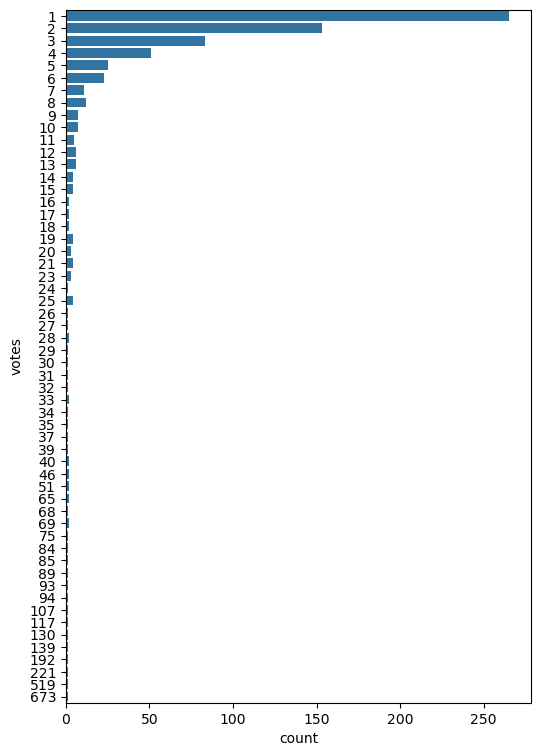

In [105]:
plt.figure(figsize=(6,9))
sns.countplot(data=data, y='votes')

## Concat with the df of the ratings previously scrapped

In [97]:
df_ratings_scrapped = pd.read_csv('Datasets/df_ratings.csv')
df_ratings_scrapped.shape

(137202, 5)

In [98]:
df_ratings = pd.concat([df_ratings_scrapped, data])
df_ratings.reset_index(drop=True, inplace=True)
df_ratings.shape

(137928, 5)

In [99]:
print(f'{df_ratings.shape[0]} albums\n{df_ratings.artist.nunique()} different artists')

137928 albums
52764 different artists


In [101]:
min_votes = 20

print(f'{round((df_ratings[df_ratings['votes']<min_votes].shape[0] / df_ratings.shape[0])*100,2)}% of the albums have less than {min_votes} votes')

71.78% of the albums have less than 20 votes


In [102]:
def check_duplicates(df):
    if df['album_id'].duplicated().sum() == 0:
        print('No duplicates')
    else: 
        duplicates = df['album_id'].duplicated().sum()
        df.drop_duplicates(subset='album_id', inplace=True)
        df.reset_index(drop=True, inplace=True)
        print(f'Found {duplicates} duplicates')
        print(f'Resulting dataset: {df.shape}')

In [103]:
check_duplicates(df_ratings)

No duplicates


## **Exporting to csv (and importing in case needed)**

In [104]:
df_ratings.to_csv('Datasets/df_ratings.csv', index=False)

In [ ]:
# in case I have to import it again
# df_ratings = pd.read_csv('Datasets/df_ratings.csv', keep_default_na=False)

In [74]:
df_ratings[df_ratings['album'].isna()]

,album_id,artist,album,rating,votes
15412,35979,Meshuggah,NaN,3.78,314
35537,165451,Permanent Ruin,NaN,3.50,2
37191,167752,Cloak of Altering,NaN,3.00,1
41044,173169,Involved,NaN,5.00,1
50098,186186,Cachexic,NaN,4.00,1
63311,205403,Gore Beyond Necropsy,NaN,2.50,2
65665,208903,Arco,NaN,4.50,1
65899,209225,Nisennenmondai,NaN,3.92,6
67477,211759,Duke Ellington,NaN,3.50,1
70169,215723,Soundtrack (Film),NaN,4.17,3


In [ ]:
# df_ratings.iloc[15417]['album']

'None'

In [ ]:
# replace the null values for the actual name of the album
# df_ratings['album'] = np.where(df_ratings['album_id']==35979, 'None' , df_ratings['album'])
# df_ratings.iloc[15417]['album']

'None'

## **Statistics**

**Top rated albums**

In [75]:
df_ratings.sort_values(['rating', 'votes'], ascending=False).query('votes>100').head(10)

,album_id,artist,album,rating,votes
84117,23820,Sigur Ros,Heima (DVD),4.65,388
381,531,Pink Floyd,Wish You Were Here,4.63,7065
93258,40844,Pink Floyd,Live At Pompeii,4.62,363
1680,2532,Deep Purple,Made In Japan,4.61,513
6901,11956,The Who,Live at Leeds (Deluxe Edition),4.59,184
23553,92289,Dir En Grey,Uroboros (Remastered & Expanded),4.59,124
1090,1448,Nas,Illmatic,4.58,3844
1281,1760,Wu-Tang Clan,Enter the Wu-Tang (36 Chambers),4.58,3444
1011,1343,Miles Davis,Kind of Blue,4.58,2607
15536,36342,Coheed and Cambria,Neverender,4.58,437


**Most voted albums**

In [76]:
df_ratings.sort_values('votes', ascending=False).head(10)

,album_id,artist,album,rating,votes
1110,1484,Radiohead,OK Computer,4.54,9186
57,116,Metallica,Master Of Puppets,4.45,8950
66,130,Pink Floyd,The Dark Side Of The Moon,4.55,8048
137,222,Metallica,Ride The Lightning,4.42,8013
140,226,Radiohead,Kid A,4.43,7685
179,281,Metallica,...And Justice For All,4.19,7312
1991,3015,Metallica,Metallica,3.70,7285
42,92,Tool,Lateralus,4.45,7254
335,471,Nirvana,Nevermind,4.07,7191
381,531,Pink Floyd,Wish You Were Here,4.63,7065


In [77]:
df_ratings.artist.value_counts().head(10)

artist
Buckethead                 277
Soundtrack (Film)          236
Various Artists            213
John Zorn                   93
Psychic TV                  89
Soundtrack (Video Game)     83
Johnny Cash                 80
Miles Davis                 77
Deep Purple                 75
Frank Zappa                 73
Name: count, dtype: int64

In [78]:
df_ratings[df_ratings['artist']=='Genesis'].sort_values('votes', ascending=False)

,album_id,artist,album,rating,votes
1418,2022,Genesis,Selling England by the Pound,4.46,1778
715,960,Genesis,Foxtrot,4.37,1303
2166,3300,Genesis,The Lamb Lies Down on Broadway,4.37,1242
2536,3882,Genesis,Nursery Cryme,4.14,1039
3095,5213,Genesis,A Trick of the Tail,4.13,887
2424,3695,Genesis,Trespass,3.71,760
3102,5220,Genesis,Invisible Touch,3.06,669
3096,5214,Genesis,Wind & Wuthering,3.77,599
3099,5217,Genesis,Duke,3.55,555
3101,5219,Genesis,Genesis,3.15,504


In [79]:
df_ratings[df_ratings['artist']=='Various Artists']

,album_id,artist,album,rating,votes
2405,3667,Various Artists,Music as a Weapon II,3.03,85
8166,15291,Various Artists,A Christmas Gift For You,3.82,50
11700,23878,Various Artists,No New York,4.11,68
20808,65942,Various Artists,Whom The Moon A Nightsong Sings,3.87,32
28227,155742,Various Artists,Let No One Judge You: Early Recordings from Iran,3.25,2
...,...,...,...,...,...
131718,96984,Various Artists,Punk Goes Pop 4,2.15,17
133981,100142,Various Artists,Elect-Lo-Nica Compilation,1.50,1
135115,101704,Various Artists,New Orleans -The Original Sound of Funk 1960-1975,3.00,1
136753,154131,Various Artists,"100 Moons: Hindustani Vocal Art, 1930-55",3.50,2


In [81]:
df_ratings[df_ratings['artist']=='Soundtrack (Film)']

,album_id,artist,album,rating,votes
5954,10169,Soundtrack (Film),South Park (Original Soundtrack),3.93,64
6021,10302,Soundtrack (Film),Pulp Fiction,3.88,85
6204,10653,Soundtrack (Film),Team America: World Police,3.97,38
6541,11286,Soundtrack (Film),The Crow,3.91,44
9511,18273,Soundtrack (Film),Garden State,3.75,46
...,...,...,...,...,...
132281,97757,Soundtrack (Film),The Hunger Games,3.17,21
133099,98837,Soundtrack (Film),Collateral,2.88,4
135567,102385,Soundtrack (Film),Ma 6-T Va Cracker,4.00,1
136583,103895,Soundtrack (Film),Fight Club,3.93,14


In [89]:
df_ratings['votes'].value_counts().head(15)

votes
1     28632
2     15339
3     10239
4      7320
5      5863
6      4645
7      3920
8      3272
9      2806
10     2442
11     2251
12     2035
13     1750
14     1555
15     1406
Name: count, dtype: int64

<Axes: xlabel='votes', ylabel='Count'>

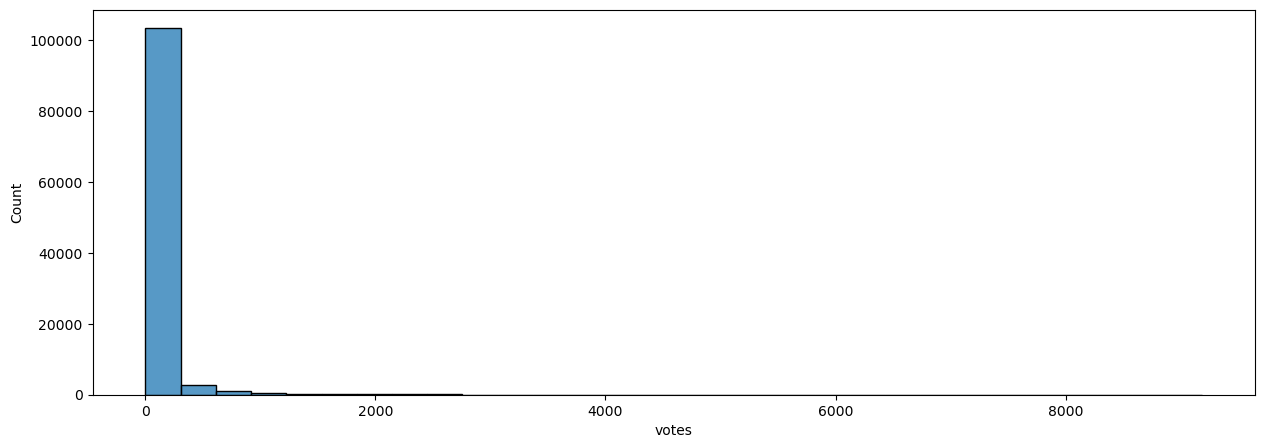

In [86]:
plt.figure(figsize=(15,5))
sns.histplot(data=df_ratings[df_ratings['votes']>1], x='votes', bins=30)

In [87]:
df_ratings.shape

(137202, 5)